In [1]:
import json
import os
import os.path as osp

import matplotlib.pyplot as plt
import numpy as np
import torch

from models import build_vae_var

In [2]:
%matplotlib inline
torch.set_printoptions(sci_mode=False)

# Load model

In [3]:
setattr(torch.nn.Linear, 'reset_parameters', lambda _: None)     # disable default parameter init for faster speed
setattr(torch.nn.LayerNorm, 'reset_parameters', lambda _: None)  # disable default parameter init for faster speed

DEVICE = "cuda"

PATCH_NUMS_256 = (1, 2, 3, 4, 5, 6, 8, 10, 13, 16)
PATCH_NUMS_512 = (1, 2, 3, 4, 6, 9, 13, 18, 24, 32)
MODEL_DEPTH = 36

assert MODEL_DEPTH in {16, 20, 24, 30, 36}

# download checkpoint
hf_home = 'https://huggingface.co/FoundationVision/var/resolve/main'
vae_ckpt = f'state_dicts/vae_ch160v4096z32.pth'
var_ckpt = f'state_dicts/var_d{MODEL_DEPTH}.pth'

if not osp.exists(vae_ckpt):
    vae_ckpt_old = vae_ckpt.removeprefix("state_dicts/")
    os.system(f'wget {hf_home}/{vae_ckpt_old}')
    os.rename(vae_ckpt_old, vae_ckpt)
if not osp.exists(var_ckpt):
    var_ckpt_old = var_ckpt.removeprefix("state_dicts/")
    os.system(f'wget {hf_home}/{var_ckpt_old}')
    os.rename(var_ckpt_old, var_ckpt)

# build vae, var
patch_nums = PATCH_NUMS_512 if MODEL_DEPTH == 36 else PATCH_NUMS_256
if 'vae' not in globals() or 'var' not in globals():
    vae, var = build_vae_var(
        V=4096, Cvae=32, ch=160, share_quant_resi=4,    # hard-coded VQVAE hyperparameters
        device=DEVICE, patch_nums=patch_nums,
        num_classes=1000, depth=MODEL_DEPTH, shared_aln=(MODEL_DEPTH == 36),
    )

# load checkpoints
vae.load_state_dict(torch.load(vae_ckpt, map_location='cpu'), strict=True)
var.load_state_dict(torch.load(var_ckpt, map_location='cpu'), strict=True)
vae.eval()
var.eval()
for p in vae.parameters(): p.requires_grad_(False)
for p in var.parameters(): p.requires_grad_(False)
print(f'prepare finished.')


[constructor]  ==== flash_if_available=True (0/36), fused_if_available=True (fusing_add_ln=0/36, fusing_mlp=0/36) ==== 
     [VAR config] embed_dim=2304, num_heads=36, depth=36, mlp_ratio=4.0
    [drop ratios] drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.15 (tensor([0.0000, 0.0043, 0.0086, 0.0129, 0.0171, 0.0214, 0.0257, 0.0300, 0.0343,
        0.0386, 0.0429, 0.0471, 0.0514, 0.0557, 0.0600, 0.0643, 0.0686, 0.0729,
        0.0771, 0.0814, 0.0857, 0.0900, 0.0943, 0.0986, 0.1029, 0.1071, 0.1114,
        0.1157, 0.1200, 0.1243, 0.1286, 0.1329, 0.1371, 0.1414, 0.1457, 0.1500]))

[init_weights] VAR with init_std=0.0120281
prepare finished.


# Define sampling process

In [4]:
# set args
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# run faster
tf32 = True
torch.backends.cudnn.allow_tf32 = bool(tf32)
torch.backends.cuda.matmul.allow_tf32 = bool(tf32)
torch.set_float32_matmul_precision('high' if tf32 else 'highest')

In [5]:
def sample(
    batch_size: int,
    class_label: int,
    w_cfg: int | float | list[torch.Tensor],
    w_igg: float = 0.,
    seed: int = 0,
    show_heatmap: bool = False
):
    if batch_size > 1 and show_heatmap:
        raise ValueError("Heatmaps can only be displayed for batch size 1")

    if w_igg != 0 and show_heatmap:
        nrows = 4
    elif not show_heatmap:
        nrows = 2
    else:
        nrows = 1
    if batch_size == 1:
        ncols = len(patch_nums)
    else:
        ncols = batch_size
    figsize = (2.5 * ncols, 2.5 * nrows)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    fig.subplots_adjust(hspace=.05, wspace=.05)

    with torch.inference_mode():
        with torch.autocast("cuda", enabled=True, dtype=torch.float16, cache_enabled=True): # using bfloat16 can be faster
            out = var.autoregressive_infer_cfg(
                B=batch_size,
                label_B=class_label,
                w_cfg=w_cfg,
                w_igg=None,
                top_k=900,
                top_p=0.95,
                g_seed=seed,
                return_all_scales=batch_size==1
            )
            if isinstance(out, tuple):
                imgs, nudge_atns_no_guide, self_atns_no_guide, cross_atns_no_guide = out
            else:
                imgs = out

    ax_ = ax[0] if nrows > 1 else ax
    for j, img in enumerate(imgs):
        ax_[j].axis("off")
        ax_[j].imshow(img.float().permute(1, 2, 0))

    if nrows == 1:
        return fig

    with torch.inference_mode():
        with torch.autocast("cuda", enabled=True, dtype=torch.float16, cache_enabled=True):
            out = var.autoregressive_infer_cfg(
                B=batch_size,
                label_B=class_label,
                w_cfg=None,
                w_igg=w_igg,
                top_k=900,
                top_p=0.95,
                g_seed=seed,
                return_all_scales=batch_size==1
            )
            if isinstance(out, tuple):
                atn_imgs, nudge_atns, self_atns, cross_atns = out
            else:
                atn_imgs = out

    ax_ = ax[2] if nrows > 2 else ax[1]
    for j, img in enumerate(atn_imgs):
        ax_[j].axis("off")
        ax_[j].imshow(img.float().permute(1, 2, 0))

    if nrows == 2:
        return fig

    for j, (ndg, _, _) in enumerate(zip(nudge_atns_no_guide, self_atns_no_guide, cross_atns_no_guide)):
        ax[1,j].axis("off")
        ax[1,j].imshow(ndg.reshape(int(ndg.shape[0]**.5), int(ndg.shape[0]**.5)))
        # ax[2,j].axis("off")
        # ax[3,j].axis("off")
        # ax[2,j].imshow(satn)
        # ax[3,j].imshow(catn)

    for j, (ndg, _, _) in enumerate(zip(nudge_atns, self_atns, cross_atns)):
        ax[3,j].axis("off")
        heatmap = ax[3,j].imshow(ndg.reshape(int(ndg.shape[0]**.5), int(ndg.shape[0]**.5)))
        # ax[6,j].axis("off")
        # ax[7,j].axis("off")
        # ax[6,j].imshow(satn)
        # heatmap = ax[7,j].imshow(catn)

    cax = fig.add_axes([0.125, 0.075, 0.775, 0.02])
    cbar = fig.colorbar(heatmap, cax=cax, aspect=10, orientation="horizontal")
    cbar.set_ticks([])

    return fig

In [6]:
with open("imagenet/imagenet_classes.json", 'r') as f:
    CLASS_NAME = json.load(f)

# Attention-based guidance



## Hyperparameters

In [34]:
label = 980
w_cfg = 5.0
w_igg = 5.0

## Coarse-to-fine image generation

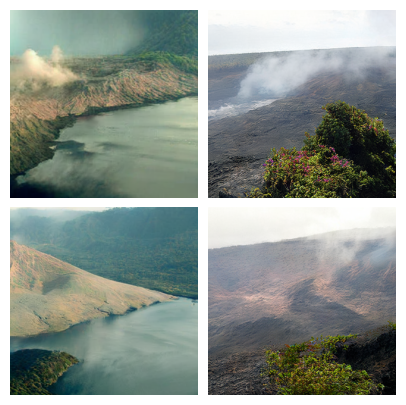

In [35]:
fig = sample(2, label, w_cfg, w_igg, show_heatmap=False)
fig.savefig(f"../figures/batch_compare/d{MODEL_DEPTH}_batch_compare_{CLASS_NAME[label].lower().replace(' ', '-')}.png", transparent=True)

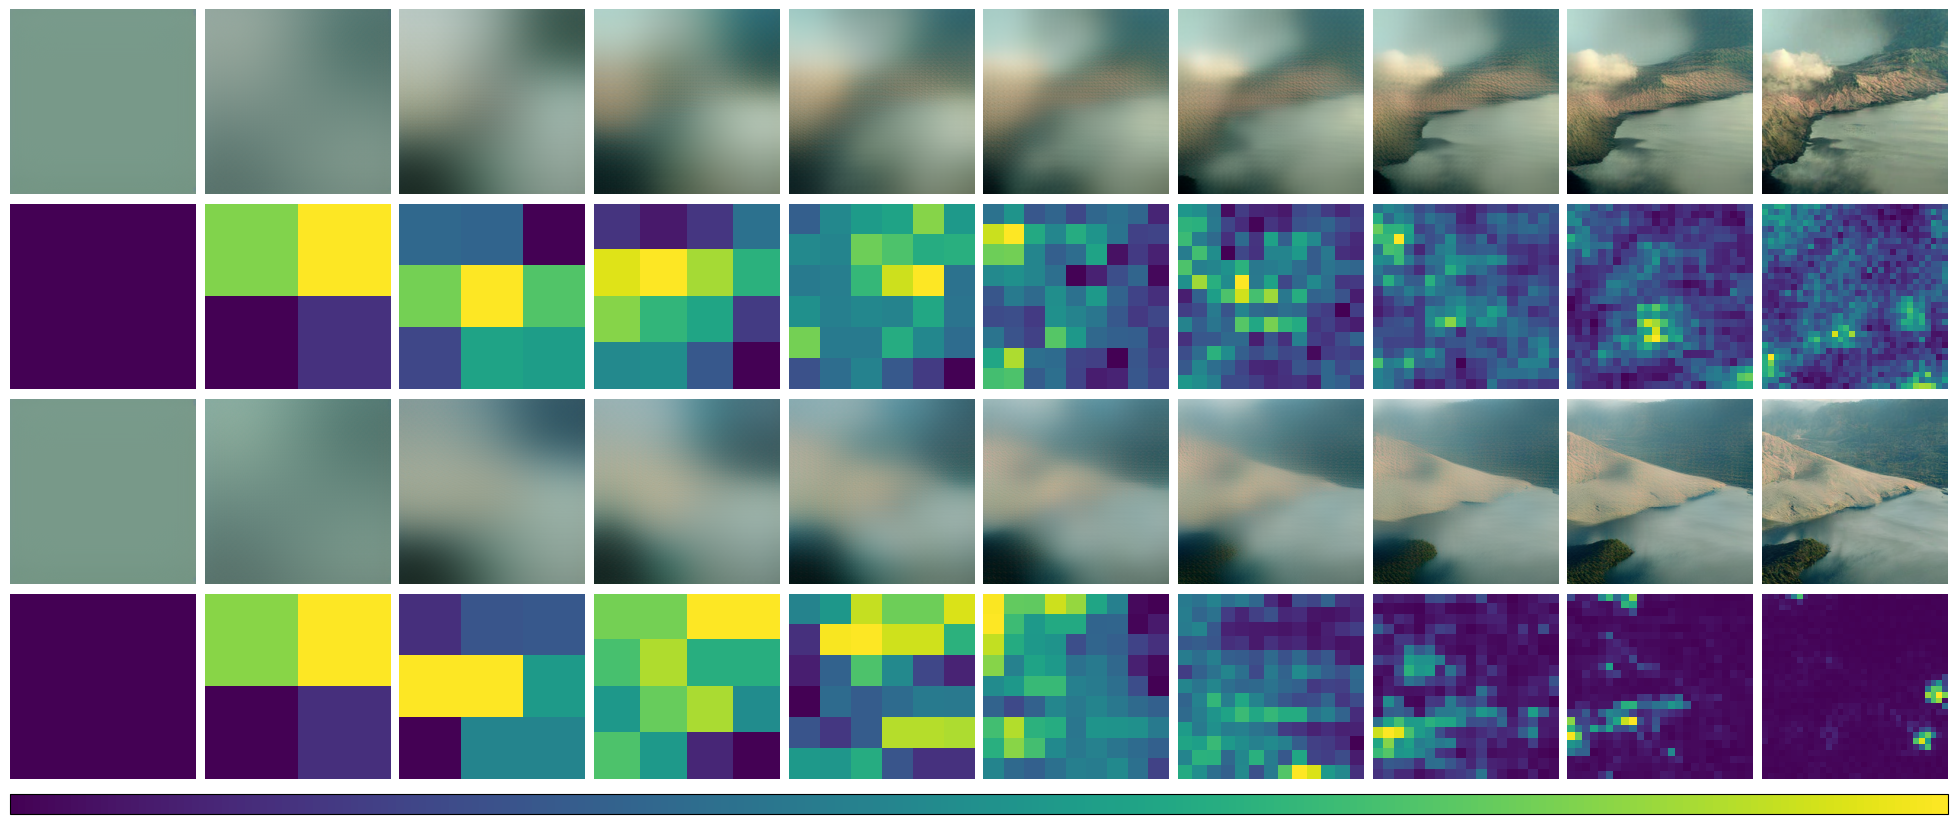

In [36]:
fig = sample(1, label, w_cfg, w_igg, show_heatmap=True)
fig.savefig(f"../figures/nudge_compare/d{MODEL_DEPTH}_nudge_compare_{CLASS_NAME[label].lower().replace(' ', '-')}.png", transparent=True)